## Introduction
The goal of this project is to develop a model to be used in fraud detection. This task presents special challenges as the class of interest - cases of fraud - are a small minority. Caution should also be exercised in the handling of outliers as these may be important in the determination of fraudulent cases.

After some exploratory data analysis, SMOTE is applied to augment the minority class. An SVM model is selected, fit, and evaluated. Then an XGBoost model is trained and evaluated. Finally, a Random Forest model is tried.

## Analysis
### Task
Given a data set of transactions labeled as either fraud (1) or not-fraud (0), develop a classification model to predict fraud status. This model should then be used to determine the validity of four transactions which are part of a 'collected evidence' file.

In [61]:
import pandas as pd
import numpy as np
import string
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import plotly.express as px
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score , precision_score , recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from IPython.display import Markdown, display as i_display
from sklearn.model_selection import RandomizedSearchCV
from prettytable import PrettyTable

import warnings
warnings.filterwarnings('ignore')

In [2]:
# read in file
trans = pd.read_csv('transactions.csv')

### Exploratory data analysis

In [6]:
trans.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Aside from _Time_, _Amount_, and _Class_ this data set contains non-descriptive features.

In [5]:
trans.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


The non-descriptive features have means close to zero.

Next, check for duplicate values.

In [7]:
print("Duplicates:", trans.duplicated().sum())

Duplicates: 1081


In [3]:
# drop duplicates
trans.drop_duplicates(inplace=True)
print("Duplicates:", trans.duplicated().sum())

Duplicates: 0


The 'collected evidence' data does not include any information about time. Thus, the _Time_ column should be removed from this data set before model training.

In [4]:
# drop 'time' feature - it's not included in the data to predict on
trans.drop(columns = 'Time', inplace=True)
trans.info()

<class 'pandas.core.frame.DataFrame'>
Index: 283726 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      283726 non-null  float64
 1   V2      283726 non-null  float64
 2   V3      283726 non-null  float64
 3   V4      283726 non-null  float64
 4   V5      283726 non-null  float64
 5   V6      283726 non-null  float64
 6   V7      283726 non-null  float64
 7   V8      283726 non-null  float64
 8   V9      283726 non-null  float64
 9   V10     283726 non-null  float64
 10  V11     283726 non-null  float64
 11  V12     283726 non-null  float64
 12  V13     283726 non-null  float64
 13  V14     283726 non-null  float64
 14  V15     283726 non-null  float64
 15  V16     283726 non-null  float64
 16  V17     283726 non-null  float64
 17  V18     283726 non-null  float64
 18  V19     283726 non-null  float64
 19  V20     283726 non-null  float64
 20  V21     283726 non-null  float64
 21  V22     283726 

In [5]:
# check for missing values
print('Missing values:\n',trans.isna().sum())

Missing values:
 V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [6]:
# check balance of target class
print('Count of Class Feature')
print(trans.groupby('Class', observed = False)['Class'].count())

Count of Class Feature
Class
0    283253
1       473
Name: Class, dtype: int64


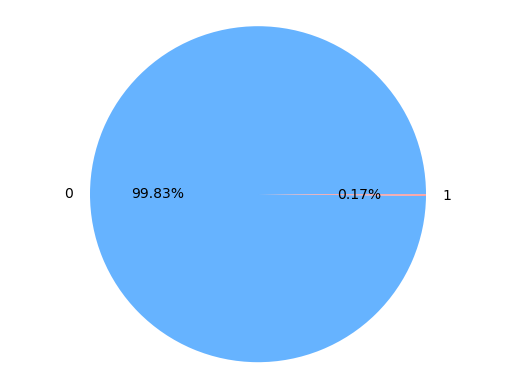

__Figure 1.__ Propotion of non-fraud to fraud transactions.

In [9]:
# create pie chart to visualize class balance
class_counts = trans['Class'].value_counts()
plt.pie(class_counts, labels=class_counts.index, autopct='%1.2f%%', colors=['#66b3ff', '#ff9999'])
plt.axis('equal')
plt.show()
i_display(Markdown("__Figure 1.__ Propotion of non-fraud to fraud transactions."))

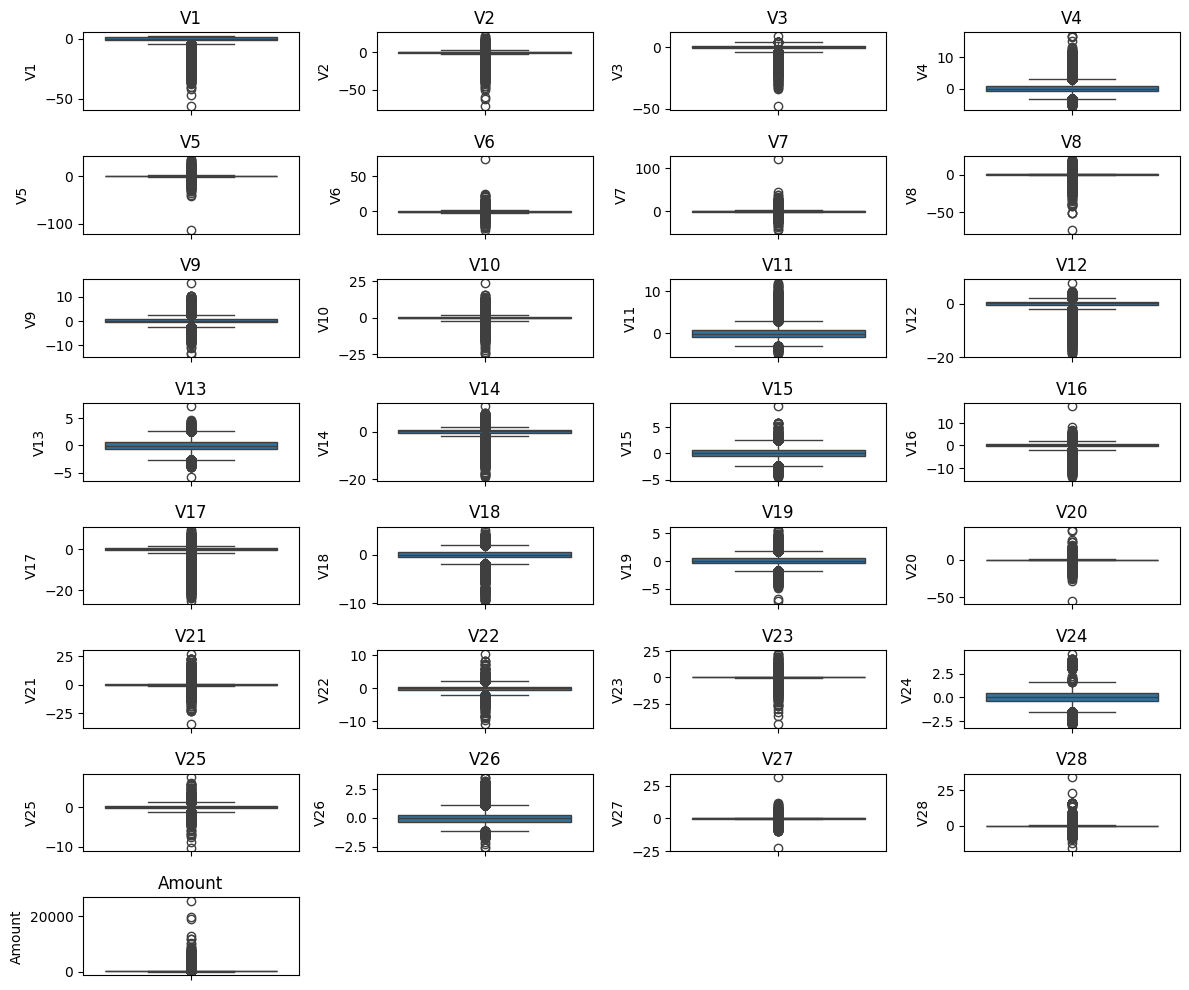

In [11]:
# outlier detection
plt.figure(figsize=(12, 10))
for i, column in enumerate(trans.columns[:-1]):
    plt.subplot(8,4,i+1)
    sns.boxplot(y = column, data = trans)
    plt.title(f'{column}')
plt.tight_layout()
plt.show()

__Figure 2.__ Box plots showing distribution of features.

This data set contains many outliers. Because we are dealing with fraud detection (i.e. detection of outliers) these should not be imputed.

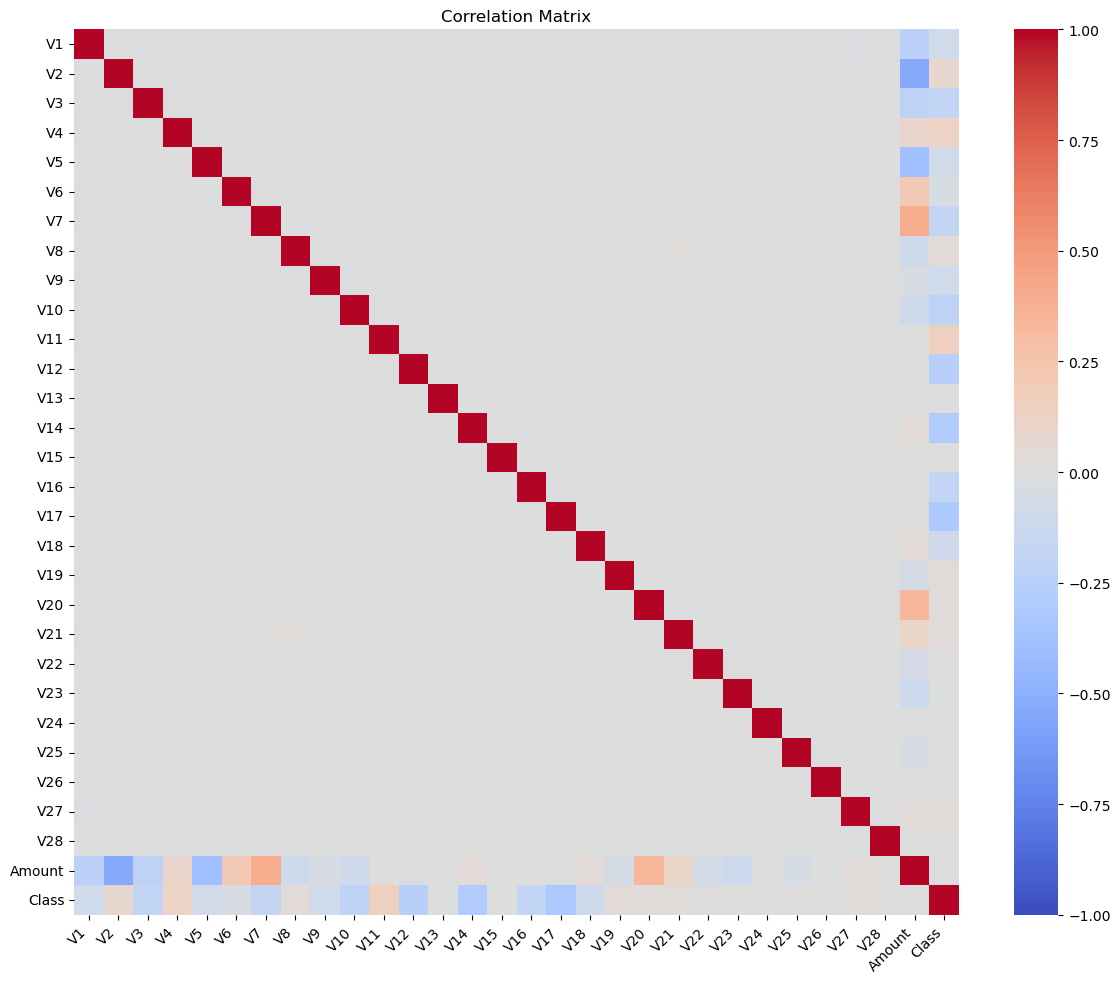

__Figure 3.__ Correlation matrix heatmap of transaction data.

In [11]:
# check correlation
correlation_matrix = trans.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=False, 
            cmap='coolwarm', 
            vmin=-1, 
            vmax=1, 
            center=0)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.xticks(rotation=45, ha='right')

plt.show()
i_display(Markdown("__Figure 3.__ Correlation matrix heatmap of transaction data."))

In [12]:
# get correlation values
corr_matrix = trans.corr()
print(corr_matrix)

              V1        V2        V3        V4        V5        V6        V7  \
V1      1.000000  0.006875 -0.008112  0.002257 -0.007036  0.000413 -0.009173   
V2      0.006875  1.000000  0.005278 -0.001495  0.005210 -0.000594  0.007425   
V3     -0.008112  0.005278  1.000000  0.002829 -0.006879 -0.001511 -0.011721   
V4      0.002257 -0.001495  0.002829  1.000000  0.001744 -0.000880  0.004657   
V5     -0.007036  0.005210 -0.006879  0.001744  1.000000 -0.000938 -0.008709   
V6      0.000413 -0.000594 -0.001511 -0.000880 -0.000938  1.000000  0.000436   
V7     -0.009173  0.007425 -0.011721  0.004657 -0.008709  0.000436  1.000000   
V8     -0.001168  0.002899 -0.001815  0.000890  0.001430  0.003036 -0.006419   
V9      0.001828 -0.000274 -0.003579  0.002154 -0.001213 -0.000734 -0.004921   
V10     0.000815  0.000620 -0.009632  0.002753 -0.006050 -0.002180 -0.013617   
V11     0.001028 -0.000633  0.002339 -0.001223  0.000411 -0.000211  0.002454   
V12    -0.001524  0.002266 -0.005900  0.

Features V1 through V28 likely represent principal components derived from another data set. Correlation amoung the features is very close to zero. Let's get a visualization on the data.

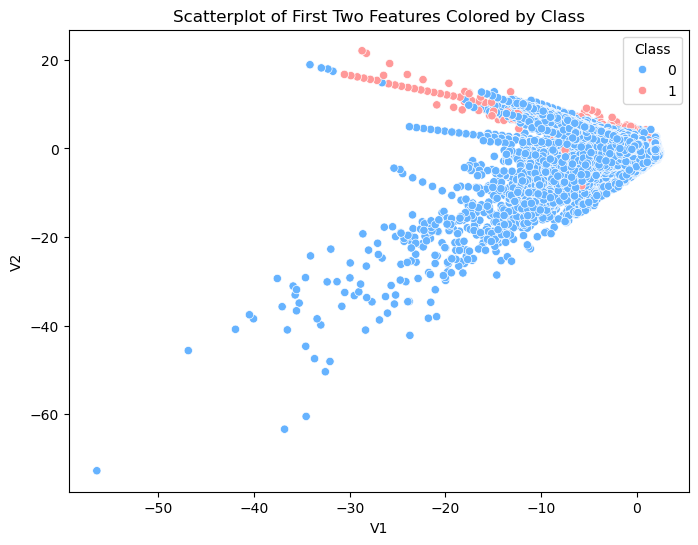

__Figure 4.__ Scatterplot of first two features, colored by Class feature.

In [13]:
# scatterplot of first two features colored by target feature, Class
plt.figure(figsize=(8, 6))
sns.scatterplot(data=trans, x=trans.columns[0], y=trans.columns[1], hue='Class', palette=['#66b3ff', '#ff9999'])

plt.xlabel(trans.columns[0])
plt.ylabel(trans.columns[1])
plt.title('Scatterplot of First Two Features Colored by Class')

plt.show()
i_display(Markdown("__Figure 4.__ Scatterplot of first two features, colored by Class feature."))

Many of the fraudulent transactions are grouped together but are not clearly separable from the valid transactions.

Next, we'll split the data into train and test sets and prepare it for modeling.

### Split the data
Data will be stratified to ensure the test data more closely reflects proportions seen in the real world. The split will be 70/30, train/test.

In [16]:
# assign target feature to y and remaining features to X
X = trans.iloc[:, :-1]
y = trans['Class']
# split data into train and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
# check results
print("Training dataset shape:", X_train.shape)
print("Testing dataset shape:", X_test.shape)

Training dataset shape: (198608, 29)
Testing dataset shape: (85118, 29)


#### Verify stratification

In [17]:
# Calculate proportions for training set
unique_train, counts_train = np.unique(y_train, return_counts=True)
train_label_proportions = counts_train / counts_train.sum()

# Calculate proportions for testing set
unique_test, counts_test = np.unique(y_test, return_counts=True)
test_label_proportions = counts_test / counts_test.sum()

print("(a) Proportions of labels in training set:")
for label, proportion in zip(unique_train, train_label_proportions):
    print(f"Label {label}: {proportion:.5f}")

print("\n(b) Proportions of labels in testing set:")
for label, proportion in zip(unique_test, test_label_proportions):
    print(f"Label {label}: {proportion:.5f}")

(a) Proportions of labels in training set:
Label 0: 0.99833
Label 1: 0.00167

(b) Proportions of labels in testing set:
Label 0: 0.99833
Label 1: 0.00167


The proportions look good.

#### Augment training data set
Use Synthetic Minority Over-sampling Technique (SMOTE) to increase observations in minority class. This will give the model more opportunity to learn to recognize the fraud observations. This should be done on the training data only. Test data should remain untouched.

In [18]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check distribution of the resampled data
unique_train_resampled, counts_train_resampled = np.unique(y_train_resampled, return_counts=True)
train_label_proportions_resampled = counts_train_resampled / counts_train_resampled.sum()

# Display new label proportions
print("Proportions of labels after applying SMOTE:")
for label, proportion in zip(unique_train_resampled, train_label_proportions_resampled):
    print(f"Label {label}: {proportion:.5f}")

#(OpenAI)

Proportions of labels after applying SMOTE:
Label 0: 0.50000
Label 1: 0.50000


#### Normalize data
This is an important preprocessing step for Support Vector Machine (SVM) and many other machine learning models. Otherwise, features recorded on different scales may have undue influence. Normalization can improve model performance.

In [19]:
scaler = MinMaxScaler()
X_train_resampled = pd.DataFrame(scaler.fit_transform(X_train_resampled), columns = X_train_resampled.columns)
X_train_resampled.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.994638,0.742146,0.768466,0.158090,0.477478,0.653813,0.519182,0.804110,0.477645,0.533341,...,0.376710,0.560290,0.506392,0.597397,0.520923,0.516877,0.432645,0.653996,0.256301,0.000714
1,0.921751,0.771981,0.795694,0.304285,0.482450,0.524875,0.558058,0.797249,0.413133,0.498754,...,0.383327,0.560412,0.431443,0.592289,0.486251,0.524077,0.305870,0.643227,0.252193,0.000001
2,0.856353,0.705335,0.754015,0.350969,0.465910,0.550545,0.559582,0.798742,0.431585,0.513559,...,0.391695,0.559340,0.437142,0.601350,0.303702,0.521286,0.391865,0.676336,0.232101,0.028745
3,0.992634,0.761607,0.772459,0.246420,0.477074,0.569450,0.546037,0.792364,0.499715,0.511190,...,0.381584,0.561817,0.485388,0.597027,0.367322,0.507981,0.506379,0.649603,0.255914,0.000053
4,0.960834,0.775782,0.768401,0.229331,0.496870,0.526652,0.571445,0.786411,0.463279,0.485742,...,0.380879,0.565036,0.508898,0.586727,0.305601,0.547715,0.406807,0.650750,0.257387,0.000246


In [20]:
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)
X_test.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.896911,0.802908,0.936258,0.274322,0.777170,0.229813,0.220152,0.716931,0.510358,0.645357,...,0.582955,0.535216,0.605842,0.666944,0.386909,0.612446,0.355447,0.229732,0.490047,0.000757
1,0.921195,0.796043,0.952536,0.247004,0.777681,0.230629,0.221559,0.715826,0.497095,0.585576,...,0.580726,0.528013,0.543783,0.664254,0.327618,0.659135,0.479113,0.235803,0.494686,0.001220
2,0.968883,0.786826,0.924595,0.270079,0.775420,0.229162,0.215127,0.718981,0.505446,0.601596,...,0.578833,0.527351,0.531957,0.671570,0.332869,0.637323,0.444121,0.238037,0.493419,0.000035
3,0.968798,0.775828,0.929644,0.261341,0.771257,0.236828,0.211416,0.718744,0.475852,0.629050,...,0.577094,0.527900,0.562050,0.665618,0.269666,0.668593,0.392956,0.239921,0.493876,0.003250
4,0.959193,0.761478,0.943890,0.246059,0.762126,0.235449,0.208207,0.721045,0.539134,0.610605,...,0.584983,0.538798,0.593362,0.666429,0.399723,0.644452,0.403906,0.239334,0.495059,0.009731


#### Train SVM model
A Support Vector Machine Model will be trained and evaluated. This may not be the optimal choice due to the large number of rows in the data set, but perhaps the kernel trick will be able to separate the two classes. First, random search will be used to find the optimal hyperparameters for the model.

In [19]:
# use random search to find optimal hyper-parameters
from sklearn.model_selection import RandomizedSearchCV

param_grid = {'C': [0.1, 1, 10, 100], 
	 'gamma': [1, 0.1, 0.01, 0.001], 
	 'kernel': ['linear','rbf','poly','sigmoid']} 

random_search = RandomizedSearchCV(SVC(), param_distributions=param_grid, n_iter=5, scoring='accuracy', 
                                   n_jobs=-1, cv=3, random_state=42, verbose=2)
random_search.fit(X_train_resampled, y_train_resampled)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................C=10, gamma=0.001, kernel=linear; total time=13.8min
[CV] END ...................C=10, gamma=0.001, kernel=linear; total time=13.9min
[CV] END .....................C=100, gamma=0.01, kernel=poly; total time=16.1min
[CV] END .....................C=100, gamma=0.01, kernel=poly; total time=16.7min
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=19.5min
[CV] END .....................C=100, gamma=0.01, kernel=poly; total time=21.5min
[CV] END ....................C=100, gamma=0.1, kernel=linear; total time=21.7min
[CV] END ....................C=100, gamma=0.1, kernel=linear; total time=22.3min
[CV] END ....................C=100, gamma=0.1, kernel=linear; total time=22.8min
[CV] END ...................C=10, gamma=0.001, kernel=linear; total time=13.4min
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=17.6min
[CV] END ......................C=0.1, gamma=1, ke

RandomizedSearchCV(cv=3, estimator=SVC(), n_iter=5, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'gamma': [1, 0.1, 0.01, 0.001],
                                        'kernel': ['linear', 'rbf', 'poly',
                                                   'sigmoid']},
                   random_state=42, scoring='accuracy', verbose=2)

In [21]:
print("Best hyperparameters:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)

Best hyperparameters: {'kernel': 'linear', 'gamma': 0.1, 'C': 100}
Best cross-validation score: 0.9632862083773238


In [23]:
# best hyperparameters: C: 100, kernel: linear, gamma: 0.1
best_params = random_search.best_params_
# fit model
svm_model = SVC(C=best_params['C'], gamma=best_params['gamma'], kernel=best_params['kernel'])
svm_model.fit(X_train_resampled, y_train_resampled)

SVC(C=100, gamma=0.1, kernel='linear')

#### Evaluate SVM model

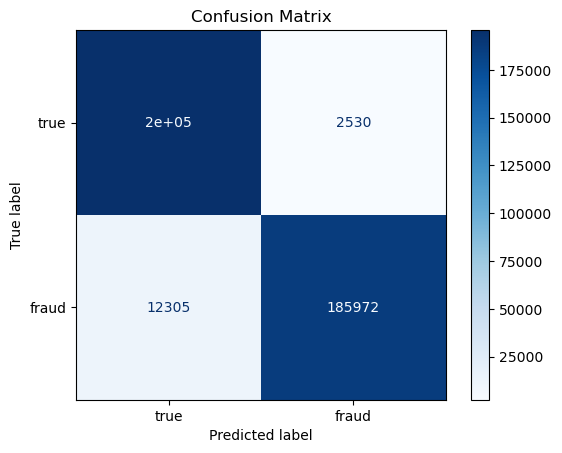

__Figure 5.__ Confusion martix for train data.

In [22]:
svm_model = SVC(C=100, gamma=0.1, kernel='linear')
svm_model.fit(X_train_resampled, y_train_resampled)
# make predictions
y_pred_tr = svm_model.predict(X_train_resampled)
# display confusion matrix
cmatrix = confusion_matrix(y_train_resampled, y_pred_tr)
display = ConfusionMatrixDisplay(confusion_matrix = cmatrix, display_labels = ['true', 'fraud'])
display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

i_display(Markdown("__Figure 5.__ Confusion martix for train data."))

In [28]:
# get performance metrics - train data
print('Performance Metrics for Train Data:\n', classification_report(y_train_resampled, y_pred_tr))

Performance Metrics for Train Data:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96    198277
           1       0.99      0.94      0.96    198277

    accuracy                           0.96    396554
   macro avg       0.96      0.96      0.96    396554
weighted avg       0.96      0.96      0.96    396554



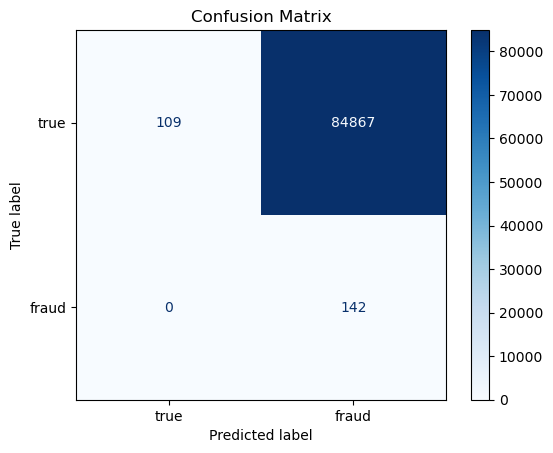

__Figure 6.__ Confusion martix for test data.

In [23]:
# make predictions on test data
y_pred_test = svm_model.predict(X_test)
# display confusion matrix
cmatrix = confusion_matrix(y_test, y_pred_test)
display = ConfusionMatrixDisplay(confusion_matrix = cmatrix, display_labels = ['true', 'fraud'])
display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

i_display(Markdown("__Figure 6.__ Confusion martix for test data."))

In [33]:
# get performance metrics - test data
print('Performance Metrics for Test Data:\n', classification_report(y_test, y_pred_test))

Performance Metrics for Test Data:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00     84976
           1       0.00      1.00      0.00       142

    accuracy                           0.00     85118
   macro avg       0.50      0.50      0.00     85118
weighted avg       1.00      0.00      0.00     85118



This model struggles to correctly identify non-fradulent transactions. F1 score is approximately zero. Let's see what is says about the transactions in 'collected evidence.'

#### Read in evidence

In [33]:
# read in evidence file
# first create column names
columns = [f'V{i}' for i in range(1, 29)] + ['Amount']
evidence = pd.read_csv('evidence.tsv', sep='\t', header=None, names=columns)
print(evidence.head())

          V1        V2         V3        V4         V5        V6         V7  \
0  -3.499108  0.258555  -4.489558  4.853894  -6.974522  3.628382   5.431271   
1 -12.224021  3.854150 -12.466766  9.648311  -2.726961 -4.445610 -21.922811   
2  -5.187878  6.967709 -13.510931  8.617895 -11.214422  0.672248  -9.462533   
3  -2.303350  1.759247  -0.359745  2.330243  -0.821628 -0.075788   0.562320   

         V8        V9        V10  ...       V20       V21       V22  \
0 -1.946734 -0.775680  -1.987773  ... -3.042626 -1.052368  0.204817   
1  0.320792 -4.433162 -11.201400  ... -2.147181 -1.159830 -1.504119   
2  5.328704 -4.897006 -11.786812  ... -0.623737  2.086083  0.760190   
3 -0.399147 -0.238253  -1.525412  ... -0.430022 -0.294166 -0.932391   

         V23       V24       V25       V26       V27       V28   Amount  
0  -2.119007  0.170279 -0.393844  0.296367  1.985913 -0.900452  2102.36  
1 -19.254328  0.544867 -4.781606 -0.007772  3.052358 -0.775036  1420.50  
2   0.716806 -0.646743 -1.

In [34]:
# normalize evidence data
scaler = MinMaxScaler()
evidence = pd.DataFrame(scaler.fit_transform(evidence), columns = evidence.columns)
evidence.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.879468,0.000000,0.685974,0.344852,0.407965,1.000000,1.000000,0.000000,0.884641,0.954942,...,0.000000,0.033107,0.754727,0.858004,0.685645,0.948604,1.000000,0.646028,0.000000,1.000000
1,0.000000,0.535924,0.079397,1.000000,0.816668,0.000000,0.000000,0.311669,0.099564,0.057050,...,0.342740,0.000000,0.000000,0.000000,1.000000,0.000000,0.637496,1.000000,0.167798,0.636058
2,0.709241,1.000000,0.000000,0.859196,0.000000,0.633870,0.455518,1.000000,0.000000,0.000000,...,0.925854,1.000000,1.000000,1.000000,0.000000,0.684157,0.852180,0.194863,0.977660,0.308064
3,1.000000,0.223678,1.000000,0.000000,1.000000,0.541222,0.822003,0.212714,1.000000,1.000000,...,1.000000,0.266693,0.252495,0.972757,0.469460,1.000000,0.000000,0.000000,1.000000,0.000000


##### Use SVM to classify evidence

In [36]:
# make predictions on evidence
predictions = svm_model.predict(evidence)
print('Predictions', predictions)

Predictions [1 1 1 0]


### XGBoost
XGBoost may be a better choice of model for this dataset. It is an optimized version of Gradient Boosting which makes use of regularization, pruning, and efficient tree construction. We'll use a random search to find the optimal hyperparameters for the model.

In [19]:
# create classifier
xgb = XGBClassifier(eval_metric='auc', random_state=42)


# hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [20, 50, 100],
    'max_depth': [2, 3, 4],
    'subsample': [0.8, 0.9, 1.0],         # proportion of samples to use
    'colsample_bytree': [0.6, 0.8, 1.0]   # proportion of features to use
}

random_search = RandomizedSearchCV(xgb, param_distributions=param_grid, n_iter=5, scoring='accuracy', 
                                   n_jobs=-1, cv=3, random_state=42, verbose=2)
random_search.fit(X_train_resampled, y_train_resampled)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rat...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [2, 3, 4],
                                        'n_estimators': [20, 50, 100],
                                        'subsample': [0.8, 0.9, 1.0]},
                   random_state=42, scoring='accuracy', verbose=2)

In [20]:
print("Best hyperparameters:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)

Best hyperparameters: {'subsample': 0.9, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
Best cross-validation score: 0.9972866237084331


In [24]:
from prettytable import PrettyTable

best_model = random_search.best_estimator_
table7 = PrettyTable()
# headers
table7.field_names = ["Parameter", "Value"]
# add rows
for param, value in random_search.best_params_.items():
    table7.add_row([param, value])

table7.align["Parameter"] = "l"
table7.align["Value"] = "l"
table7.title = "Optimal Parameters"

print(table7)
i_display(Markdown("__Table 1.__ Optimal hyperparameters for XGBoost model"))

+--------------------------+
|    Optimal Parameters    |
+------------------+-------+
| Parameter        | Value |
+------------------+-------+
| subsample        | 0.9   |
| n_estimators     | 100   |
| max_depth        | 3     |
| learning_rate    | 0.2   |
| colsample_bytree | 1.0   |
+------------------+-------+


__Table 1.__ Optimal hyperparameters for XGBoost model

In [24]:
xgb_model = XGBClassifier(subsample=0.9, n_estimators=100, max_depth=3, learning_rate=0.2, colsample_bytree=1.0)
xgb_model.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

#### Evaluate XGBoost model

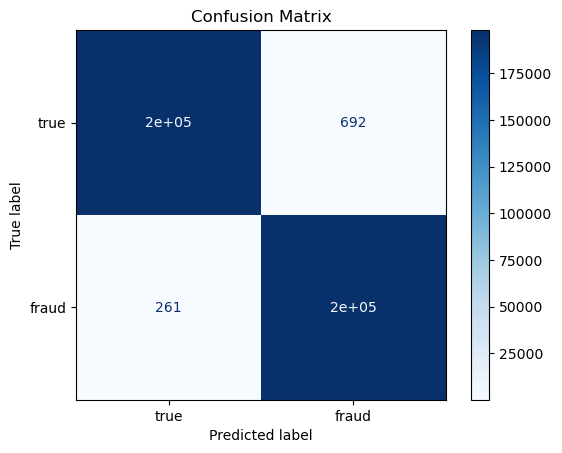

__Figure 7.__ Confusion martix for train data - XGBoost

In [25]:
# make predictions on train data
#xgb_pred = best_model.predict(X_train_resampled)
xgb_pred = xgb_model.predict(X_train_resampled)
# display confusion matrix
cmatrix = confusion_matrix(y_train_resampled, xgb_pred)
display = ConfusionMatrixDisplay(confusion_matrix = cmatrix, display_labels = ['true', 'fraud'])
display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

i_display(Markdown("__Figure 7.__ Confusion martix for train data - XGBoost"))

In [26]:
# get performance metrics - train data
print('Performance Metrics for XGBoost, Train Data:\n', classification_report(y_train_resampled, xgb_pred))

Performance Metrics for XGBoost, Train Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    198277
           1       1.00      1.00      1.00    198277

    accuracy                           1.00    396554
   macro avg       1.00      1.00      1.00    396554
weighted avg       1.00      1.00      1.00    396554



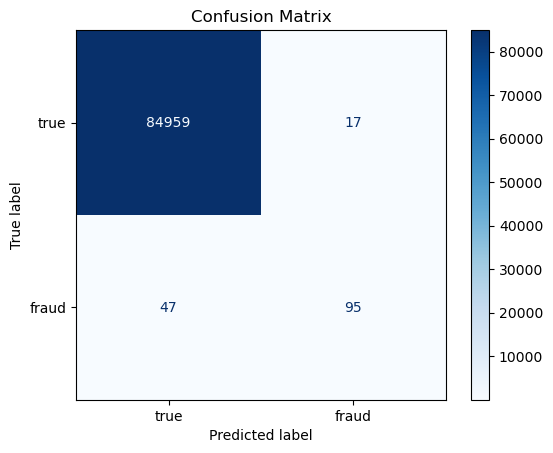

__Figure 8.__ Confusion martix for test data - XGBoost

In [29]:
# make predictions on test data
#xgb_pred_test = best_model.predict(X_test)
xgb_pred_test = xgb_model.predict(X_test)
# display confusion matrix
cmatrix = confusion_matrix(y_test, xgb_pred_test)
display = ConfusionMatrixDisplay(confusion_matrix = cmatrix, display_labels = ['true', 'fraud'])
display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

i_display(Markdown("__Figure 8.__ Confusion martix for test data - XGBoost"))

In [30]:
# get performance metrics - test data
print('Performance Metrics for XGBoost, Test Data:\n', classification_report(y_test, xgb_pred_test))
print(f'Precision: {round(precision_score(y_test, xgb_pred_test), 4)}')
print(f'Recall: {round(recall_score(y_test, xgb_pred_test), 4)}')
print(f'F1: {round(f1_score(y_test, xgb_pred_test), 4)}')

Performance Metrics for XGBoost, Test Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.85      0.67      0.75       142

    accuracy                           1.00     85118
   macro avg       0.92      0.83      0.87     85118
weighted avg       1.00      1.00      1.00     85118

Precision: 0.8482
Recall: 0.669
F1: 0.748


An F1 score of 0.75 isn't bad, but there are still many cases of fraud which are not being identified (recall is only 0.55). Let's see what it says about the 'collected evidence.'

##### Use XGBoost to classify evidence

In [35]:
# make predictions on evidence
#predictions = best_model.predict(evidence)
predictions = xgb_model.predict(evidence)
print('Predictions:', predictions)

Predictions: [0 1 1 0]


As an experiment, let's see how XGBoost does with unaugmented data.

In [35]:
# create classifier
xgb2 = XGBClassifier(eval_metric='auc', random_state=42)


# hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [20, 50, 100],
    'max_depth': [2, 3, 4],
    'subsample': [0.8, 0.9, 1.0],         # proportion of samples to use
    'colsample_bytree': [0.6, 0.8, 1.0]   # proportion of features to use
}

random_search = RandomizedSearchCV(xgb2, param_distributions=param_grid, n_iter=5, scoring='f1', 
                                   n_jobs=-1, cv=3, random_state=42, verbose=2)
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rat...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [2, 3, 4],
                                        'n_estimators': [20, 50, 100],
                                        'subsample': [0.8, 0.9, 1.0]},
                   random_state=42, scoring='f1', verbose=2)

In [36]:
print("Best hyperparameters:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)

Best hyperparameters: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
Best cross-validation score: 0.8591210076490224


In [37]:
xgb2_model = random_search.best_estimator_
table8 = PrettyTable()
# headers
table8.field_names = ["Parameter", "Value"]
# add rows
for param, value in random_search.best_params_.items():
    table8.add_row([param, value])

table8.align["Parameter"] = "l"
table8.align["Value"] = "l"
table8.title = "Optimal Parameters"

print(table8)
i_display(Markdown("__Table 2.__ Optimal hyperparameters for XGBoost 2 model"))

+--------------------------+
|    Optimal Parameters    |
+------------------+-------+
| Parameter        | Value |
+------------------+-------+
| subsample        | 1.0   |
| n_estimators     | 100   |
| max_depth        | 3     |
| learning_rate    | 0.2   |
| colsample_bytree | 0.8   |
+------------------+-------+


__Table 2.__ Optimal hyperparameters for XGBoost 2 model

In [41]:
xgb2_model = XGBClassifier(subsample=1.0, n_estimators=100, max_depth=3, learning_rate=0.2, colsample_bytree=0.8)
xgb2_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

#### Evaluate second XGBoost model

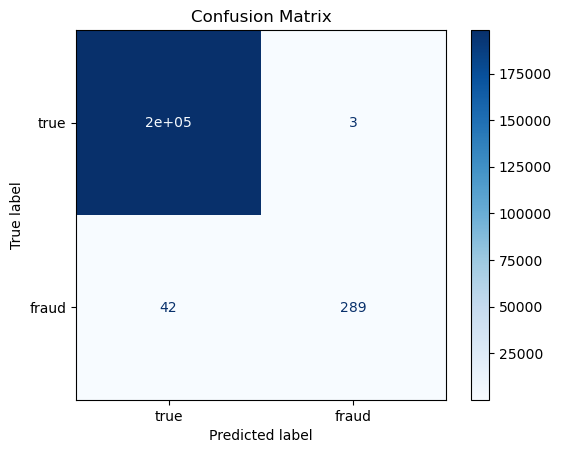

__Figure 9.__ Confusion martix for train data - XGBoost 2

In [42]:
# make predictions on train data
xgb2_pred = xgb2_model.predict(X_train)
# display confusion matrix
cmatrix = confusion_matrix(y_train, xgb2_pred)
display = ConfusionMatrixDisplay(confusion_matrix = cmatrix, display_labels = ['true', 'fraud'])
display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

i_display(Markdown("__Figure 9.__ Confusion martix for train data - XGBoost 2"))

In [43]:
# get performance metrics - train data
print('Performance Metrics for XGBoost 2, Train Data:\n', classification_report(y_train, xgb2_pred))

Performance Metrics for XGBoost 2, Train Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    198277
           1       0.99      0.87      0.93       331

    accuracy                           1.00    198608
   macro avg       0.99      0.94      0.96    198608
weighted avg       1.00      1.00      1.00    198608



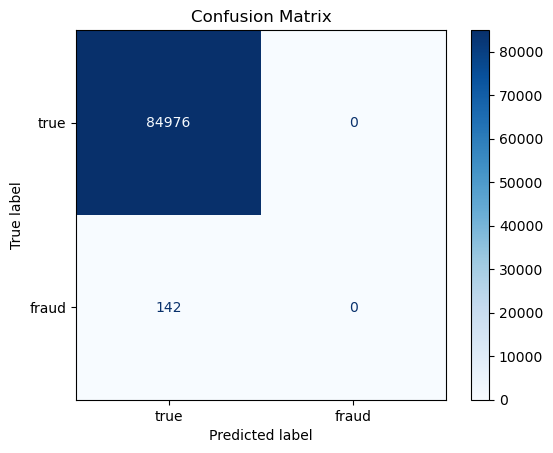

__Figure 10.__ Confusion martix for test data - XGBoost 2

In [44]:
# make predictions on test data
xgb2_pred_test = xgb2_model.predict(X_test)
# display confusion matrix
cmatrix = confusion_matrix(y_test, xgb2_pred_test)
display = ConfusionMatrixDisplay(confusion_matrix = cmatrix, display_labels = ['true', 'fraud'])
display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

i_display(Markdown("__Figure 10.__ Confusion martix for test data - XGBoost 2"))

In [45]:
# get performance metrics - test data
print('Performance Metrics for XGBoost 2, Test Data:\n', classification_report(y_test, xgb2_pred_test))

Performance Metrics for XGBoost 2, Test Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.00      0.00      0.00       142

    accuracy                           1.00     85118
   macro avg       0.50      0.50      0.50     85118
weighted avg       1.00      1.00      1.00     85118



Model performance with unaugmented data is poor. The model is unable to identify cases of fraud. Next, we'll try using a grid search for hyperparameters and go back to using the augmented data.

#### Grid search for XGBoost

In [51]:
from sklearn.model_selection import GridSearchCV

# parameters
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],  # Control how much each tree contributes
    'max_depth': [2, 3, 4],  # Tree depth, larger values can cause overfitting
    'n_estimators': [50, 100, 150],  # Number of boosting rounds (trees)
    'subsample': [0.6, 0.8, 1],  # Fraction of samples used for fitting trees
    'colsample_bytree': [0.7, 1]  # Fraction of features used for each tree
}

# create model
xgb3 = XGBClassifier(random_state=42)

# perform gridsearch
grid_search = GridSearchCV(xgb3, param_grid, cv=3, scoring='f1', verbose=2, n_jobs=-1)

# fit model
grid_search.fit(X_train_resampled, y_train_resampled)

# print hyperparameters
print("Best parameters found: ", grid_search.best_params_)

# print best score - F1
print("Best F1 score: ", grid_search.best_score_)

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best parameters found:  {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 150, 'subsample': 0.8}
Best F1 score:  0.9996269329069433


In [54]:
xgb3_model = grid_search.best_estimator_
table9 = PrettyTable()
# headers
table9.field_names = ["Parameter", "Value"]
# add rows
for param, value in random_search.best_params_.items():
    table9.add_row([param, value])

table9.align["Parameter"] = "l"
table9.align["Value"] = "l"
table9.title = "Optimal Parameters"

print(table9)
i_display(Markdown("__Table 3.__ Optimal hyperparameters for XGBoost 3 model"))

+--------------------------+
|    Optimal Parameters    |
+------------------+-------+
| Parameter        | Value |
+------------------+-------+
| subsample        | 1.0   |
| n_estimators     | 100   |
| max_depth        | 3     |
| learning_rate    | 0.2   |
| colsample_bytree | 0.8   |
+------------------+-------+


__Table 3.__ Optimal hyperparameters for XGBoost 3 model

These are the same hyperparameters as the previous model (see Table 2).

In [46]:
xgb3_model = XGBClassifier(subsample=1.0, n_estimators=100, max_depth=3, learning_rate=0.2, colsample_bytree=0.8)
xgb3_model.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

#### Evaluate thrid XGBoost model

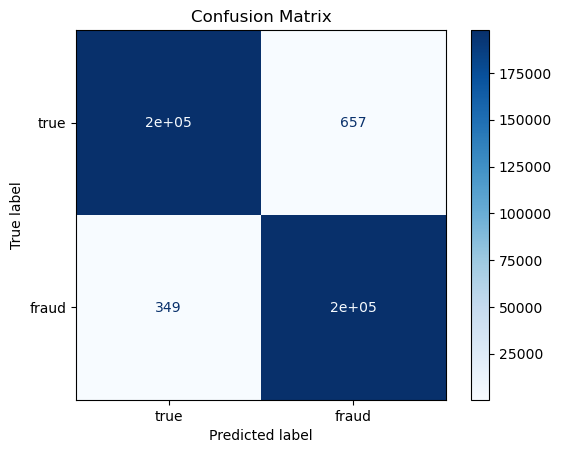

__Figure 11.__ Confusion martix for train data - XGBoost 3

In [47]:
# make predictions on train data
xgb3_pred = xgb3_model.predict(X_train_resampled)
# display confusion matrix
cmatrix = confusion_matrix(y_train_resampled, xgb3_pred)
display = ConfusionMatrixDisplay(confusion_matrix = cmatrix, display_labels = ['true', 'fraud'])
display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

i_display(Markdown("__Figure 11.__ Confusion martix for train data - XGBoost 3"))

In [48]:
# get performance metrics - train data
print('Performance Metrics for XGBoost 3, Train Data:\n', classification_report(y_train_resampled, xgb3_pred))

Performance Metrics for XGBoost 3, Train Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    198277
           1       1.00      1.00      1.00    198277

    accuracy                           1.00    396554
   macro avg       1.00      1.00      1.00    396554
weighted avg       1.00      1.00      1.00    396554



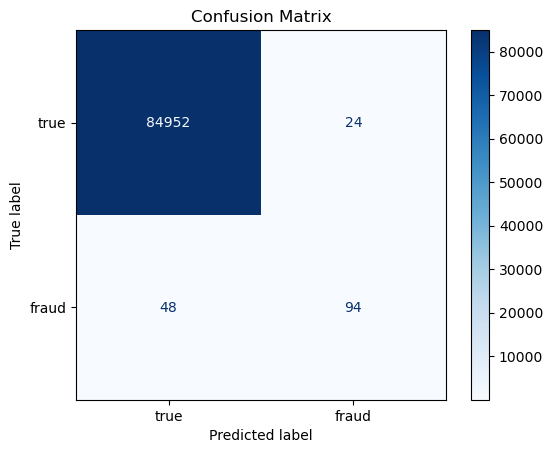

__Figure 12.__ Confusion martix for test data - XGBoost 3

In [49]:
# make predictions on test data
xgb3_pred_test = xgb3_model.predict(X_test)
# display confusion matrix
cmatrix = confusion_matrix(y_test, xgb3_pred_test)
display = ConfusionMatrixDisplay(confusion_matrix = cmatrix, display_labels = ['true', 'fraud'])
display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

i_display(Markdown("__Figure 12.__ Confusion martix for test data - XGBoost 3"))

In [50]:
# get performance metrics - test data
print('Performance Metrics for XGBoost 3, Test Data:\n', classification_report(y_test, xgb3_pred_test))
print(f'Precision: {round(precision_score(y_test, xgb3_pred_test), 4)}')
print(f'Recall: {round(recall_score(y_test, xgb3_pred_test), 4)}')
print(f'F1: {round(f1_score(y_test, xgb3_pred_test), 4)}')

Performance Metrics for XGBoost 3, Test Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.80      0.66      0.72       142

    accuracy                           1.00     85118
   macro avg       0.90      0.83      0.86     85118
weighted avg       1.00      1.00      1.00     85118

Precision: 0.7966
Recall: 0.662
F1: 0.7231


High precision means that the model is doing well correctly identifying fraud - few false positives. The model has been able to correctly identify about 60% of all actual cases of fraud.

##### Use 3rd XGBoost model to classify evidence

In [60]:
# make predictions on evidence
predictions = xgb3_model.predict(evidence)
print('Predictions for 3rd XGB model:', predictions)

Predictions for 3rd XGB model: [0 1 1 0]


##### Adjust decision threshold

Try adjusting the decision threshold. A lower threshold may work to help minimize missed cases of fraud (false negatives).

In [52]:
# get predicted probabilities
#xgb3_pred_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
xgb3_pred_prob = xgb3_model.predict_proba(X_test)[:, 1]

# set threshold
threshold = 0.3
xgb3_pred_test_adjusted = (xgb3_pred_prob >= threshold).astype(int)

# recalculate metrics
print(f'Precision: {precision_score(y_test, xgb3_pred_test_adjusted):.4f}')
print(f'Recall: {recall_score(y_test, xgb3_pred_test_adjusted):.4f}')
print(f'F1: {f1_score(y_test, xgb3_pred_test_adjusted):.4f}')

Precision: 0.7778
Recall: 0.6901
F1: 0.7313


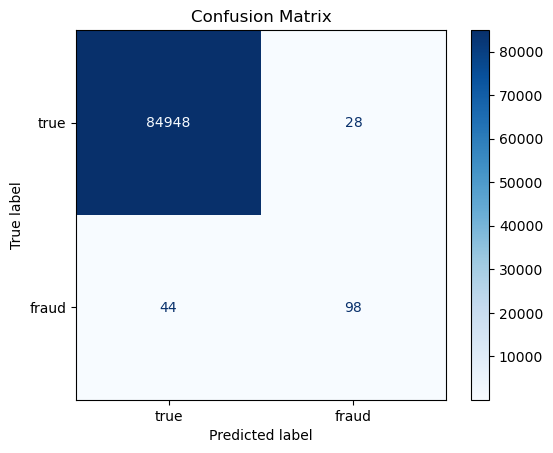

__Figure 13.__ Confusion martix for test data using XGBoost 3 with lower decision threshold

In [53]:
# display confusion matrix
cmatrix = confusion_matrix(y_test, xgb3_pred_test_adjusted)
display = ConfusionMatrixDisplay(confusion_matrix = cmatrix, display_labels = ['true', 'fraud'])
display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

i_display(Markdown("__Figure 13.__ Confusion martix for test data using XGBoost 3 with lower decision threshold"))

The trade-off between precision and recall can be visualized with a precision-recall curve. These metrics can then be used to determine the optimal F1 score.

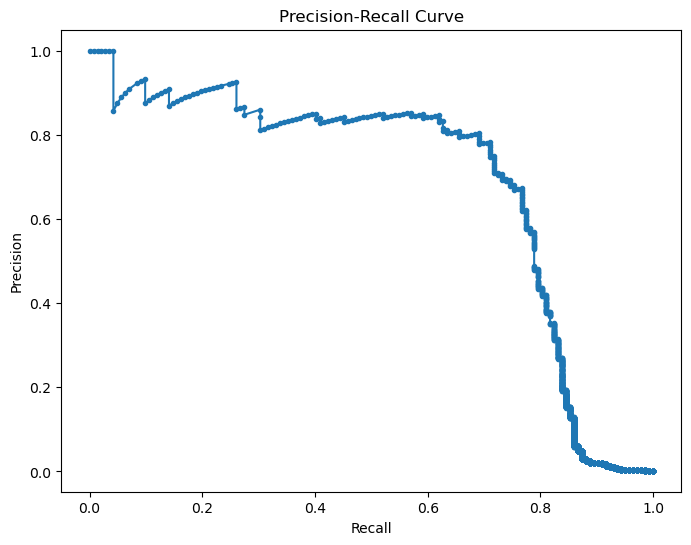

__Figure 14.__ Precision-Recall curve for XGBoost 3

Best Threshold: 0.2848


In [54]:
from sklearn.metrics import precision_recall_curve

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, xgb3_pred_prob)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()
i_display(Markdown("__Figure 14.__ Precision-Recall curve for XGBoost 3"))

# threshold that maximizes F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]
print(f'Best Threshold: {best_threshold:.4f}')

#(Bobbitt, 2021)

In [55]:
# set threshold
threshold = best_threshold
xgb3_pred_test_adjusted = (xgb3_pred_prob >= threshold).astype(int)

# recalculate metrics
print(f'Precision: {precision_score(y_test, xgb3_pred_test_adjusted):.4f}')
print(f'Recall: {recall_score(y_test, xgb3_pred_test_adjusted):.4f}')
print(f'F1: {f1_score(y_test, xgb3_pred_test_adjusted):.4f}')

Precision: 0.7829
Recall: 0.7113
F1: 0.7454


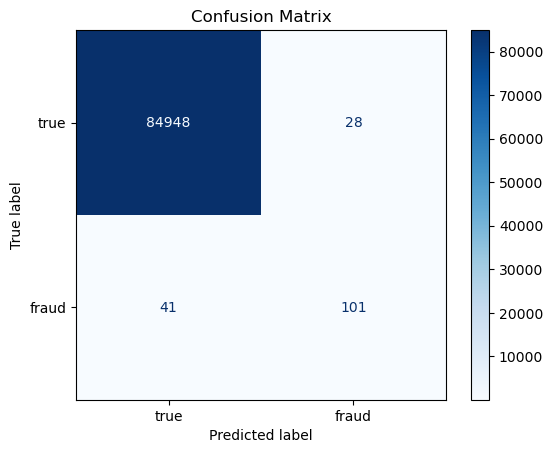

__Figure 15.__ Confusion martix for test data using XGBoost 3 with decision threshold optimized for F1 score

In [56]:
# display confusion matrix
cmatrix = confusion_matrix(y_test, xgb3_pred_test_adjusted)
display = ConfusionMatrixDisplay(confusion_matrix = cmatrix, display_labels = ['true', 'fraud'])
display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

i_display(Markdown("__Figure 15.__ Confusion martix for test data using XGBoost 3 with decision threshold optimized for F1 score"))

This is the best model so far. It correctly identifies 71% of fraudulent transactions while flagging few valid ones.

##### Use 3rd XGBoost model with optimized decision threshold to classify evidence

In [57]:
# get predicted probabilities for evidence data
pred_prob_evidence = xgb3_model.predict_proba(evidence)[:, 1]
# apply optimal threshold
predictions = (pred_prob_evidence >= best_threshold).astype(int)
print('Predictions for 3rd XGB model with optimized decision threshold:', predictions)

Predictions for 3rd XGB model with optimized decision threshold: [0 1 1 0]


#### Random Forest

Another effective choice for fraud detection might be Random Forest, which is resistant to overfitting and noise. It may be an effective choice for this data set.

In [65]:
from sklearn.ensemble import RandomForestClassifier

# create model
rf = RandomForestClassifier(random_state=42)

# parameters
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30]
}

# perform gridsearch
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=2)

# fit model
grid_search.fit(X_train_resampled, y_train_resampled)

# print hyperparameters
print("Best parameters found: ", grid_search.best_params_)

# print best score - F1
print("Best F1 score: ", grid_search.best_score_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best parameters found:  {'max_depth': 30, 'n_estimators': 100}
Best F1 score:  0.9998814957582113


In [66]:
rf_model = grid_search.best_estimator_
table10 = PrettyTable()
# headers
table10.field_names = ["Parameter", "Value"]
# add rows
for param, value in grid_search.best_params_.items():
    table10.add_row([param, value])

table10.align["Parameter"] = "l"
table10.align["Value"] = "l"
table10.title = "Optimal Parameters"

print(table10)
i_display(Markdown("__Table 4.__ Optimal hyperparameters for Random Forest model"))

+----------------------+
|  Optimal Parameters  |
+--------------+-------+
| Parameter    | Value |
+--------------+-------+
| max_depth    | 30    |
| n_estimators | 100   |
+--------------+-------+


__Table 4.__ Optimal hyperparameters for Random Forest model

#### Evaluate Random Forest model

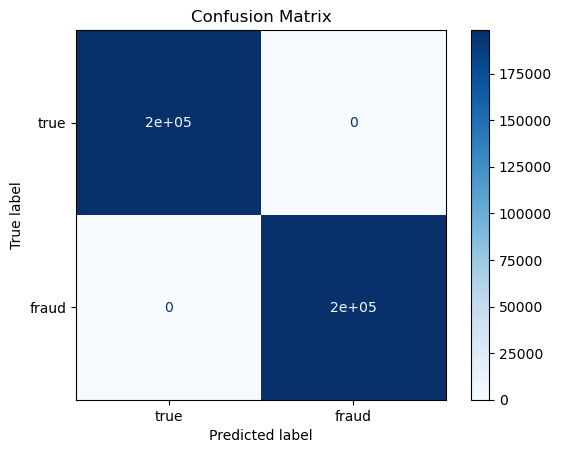

__Figure 16.__ Confusion martix for train data - Random Forest

In [67]:
# make predictions on train data
rf_pred = rf_model.predict(X_train_resampled)
# display confusion matrix
cmatrix = confusion_matrix(y_train_resampled, rf_pred)
display = ConfusionMatrixDisplay(confusion_matrix = cmatrix, display_labels = ['true', 'fraud'])
display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

i_display(Markdown("__Figure 16.__ Confusion martix for train data - Random Forest"))

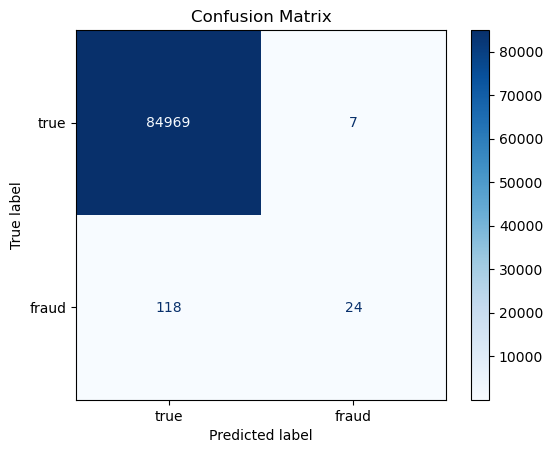

__Figure 17.__ Confusion martix for test data - Random Forest

In [69]:
# make predictions on test data
rf_pred_test = rf_model.predict(X_test)
# display confusion matrix
cmatrix = confusion_matrix(y_test, rf_pred_test)
display = ConfusionMatrixDisplay(confusion_matrix = cmatrix, display_labels = ['true', 'fraud'])
display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

i_display(Markdown("__Figure 17.__ Confusion martix for test data - Random Forest"))

This model struggles to identify instances of fraud. It finds only 17% of them.

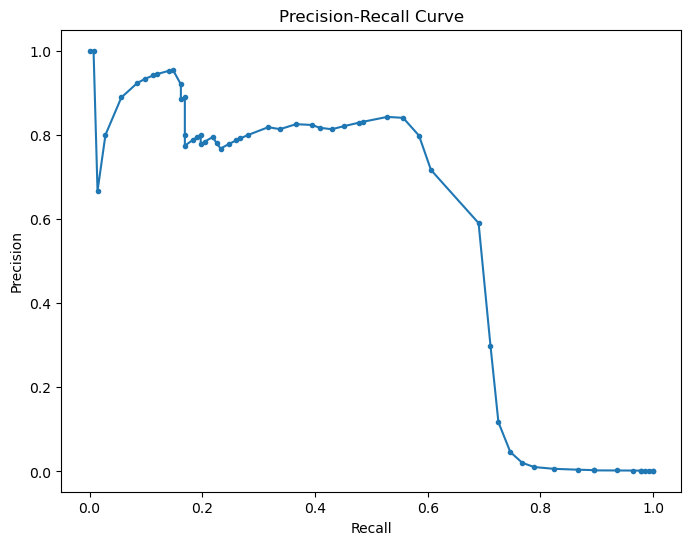

__Figure 18.__ Precision-Recall curve for Random Forest model

Best Threshold: 0.1900


In [70]:
# get predicted probabilities
rf_pred_prob = rf_model.predict_proba(X_test)[:, 1]

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, rf_pred_prob)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()
i_display(Markdown("__Figure 18.__ Precision-Recall curve for Random Forest model"))

# threshold that maximizes F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]
print(f'Best Threshold: {best_threshold:.4f}')

In [71]:
# set threshold
threshold = best_threshold
rf_pred_test_adjusted = (rf_pred_prob >= threshold).astype(int)

# recalculate metrics
print(f'Precision: {precision_score(y_test, rf_pred_test_adjusted):.4f}')
print(f'Recall: {recall_score(y_test, rf_pred_test_adjusted):.4f}')
print(f'F1: {f1_score(y_test, rf_pred_test_adjusted):.4f}')

Precision: 0.7981
Recall: 0.5845
F1: 0.6748


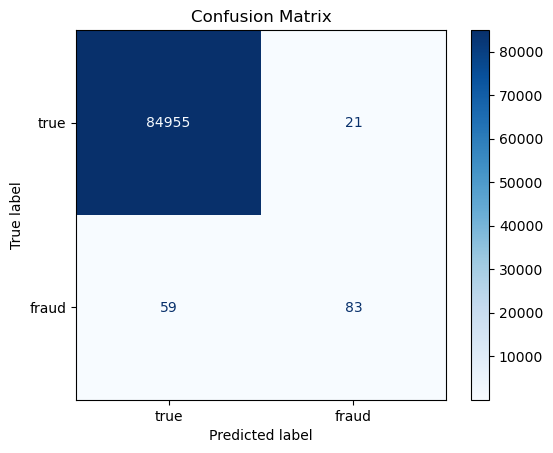

__Figure 19.__ Confusion martix for test data using Random Forest with decision threshold optimized for F1 score

In [72]:
# display confusion matrix
cmatrix = confusion_matrix(y_test, rf_pred_test_adjusted)
display = ConfusionMatrixDisplay(confusion_matrix = cmatrix, display_labels = ['true', 'fraud'])
display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

i_display(Markdown("__Figure 19.__ Confusion martix for test data using Random Forest with decision threshold optimized for F1 score"))

##### Use Random Forest model with optimized decision threshold to classify evidence

In [77]:
# get predicted probabilities for evidence data
pred_prob_evidence = rf_model.predict_proba(evidence)[:, 1]
# apply optimal threshold
predictions = (pred_prob_evidence >= best_threshold).astype(int)
print('Predictions for Random Forest model with optimized decision threshold:', predictions)

Predictions for Random Forest model with optimized decision threshold: [0 1 0 0]


This model does fairly well, but still misses many fradulent transactions. 58% of fraudulent transactions were identified. Let's compare this model to the XGBoost model.

#### Compare models

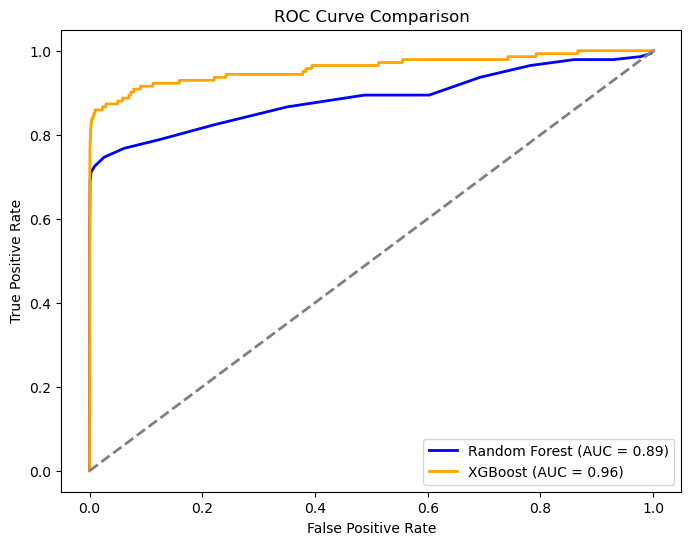

__Figure 20.__ ROC curves for Random Forest and best XGBoost models

In [75]:
from sklearn.metrics import roc_curve, auc

# compute ROC curve and AUC
fpos_rf, tpos_rf, _ = roc_curve(y_test, rf_pred_prob)
fpos_xgb3, tpos_xgb3, _ = roc_curve(y_test, xgb3_pred_prob)

roc_auc_rf = auc(fpos_rf, tpos_rf)
roc_auc_xgb3 = auc(fpos_xgb3, tpos_xgb3)

# plot curves
plt.figure(figsize=(8,6))
plt.plot(fpos_rf, tpos_rf, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpos_xgb3, tpos_xgb3, color='orange', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb3:.2f})')
# diagonal
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')

plt.show()
i_display(Markdown("__Figure 20.__ ROC curves for Random Forest and best XGBoost models"))

For this data set, the XGBoost model is the better performer.

## Conclusions

This project posed an interesting challenge. Since the minority class, which represented only 0.17% of the sample, was of interest special care needed to be taken. SMOTE was used to augment the training data, which was seen to be beneficial. Instead of relying on accuracy in model evaluation, more emphasis was placed on F1 and recall. It was interesting to see how adjusting the model decision threshold affected performance.

The XGBoost model was able to correctly identify 71% of fraudulent transactions and lowering the decision threshold would enable it to identify more (though at the cost of flagging more valid transactions). This model determined that two out of four 'collected evidence' transactions were fraudulent.

## References
Bobbitt, Z. (2021, September 9). _How to create a Precision-Recall Curve in Python._ Statology. [https://www.statology.org/precision-recall-curve-python/]

OpenAI. (2024). _ChatGPT_ (Sept 2024) [AI model]. In respose to prompt, "I'd like to apply SMOTE to the training data to increase the number of observations. How should I approach this?" on 2024/12/6 [https://www.openai.com/chatgpt]